# LINK TO GITHUB: [Ran+Shany Repo](https://github.com/RyanWri/Afeka_DL_course_labs/tree/main/src/task_2)

**All our code is organized, you can find task2 in src/task_2 directory**

In [1]:
import os
import sys
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import json
from statsmodels.tsa.seasonal import seasonal_decompose

# Allow nested use of asyncio.run()
nest_asyncio.apply()

In [2]:
os.getcwd()

'C:\\Users\\Shany\\PycharmProjects\\Afeka_DL_course_labs\\src\\task_2'

**Next Cell is for Import readibility**

In [3]:
# Prepend the src directory to the PYTHONPATH
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(),'..','..')))

# Verify that the path has been added
print(sys.path[0])

C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs


# 1 Use the dataset from UCI Machine Learning Repository
**We read the data and split it into 10 different chunks for faster reading, data files located in src/task_2/data directory**
<br>*Asyncio is an asynchornous library for fast processing time*

# 2. Perform Exploratory Data Analysis (EDA) of the dataset

In [4]:
from src.task_2.eda.eda import load_and_process_chunk

In [5]:
async def process_data_parallel():
    rootdir = os.path.join(os.getcwd(), "data")

    # Traverse Data Directory and get paths to all chunk files
    file_names = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            file_names.append(os.path.join(subdir, file))
    
    # Load and process each chunk
    tasks = [load_and_process_chunk(file) for file in file_names]
    results = await asyncio.gather(*tasks)

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(results)
    return full_df

# Run the asynchronous processing
full_df = asyncio.run(process_data_parallel())

**Plot basic stats on data**

In [6]:
def plot_dataframe_stats(df: pd.DataFrame):
    # Display basic info about the DataFrame
    print(df.info())
    print(df.head())

plot_dataframe_stats(full_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2008-12-06 07:12:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB
None
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00         

#### Creating a new feature by converting the Global active power from KW to W/h

In [7]:
def convert_kilowatt_to_watt_hour(p):
    
    if p != 'nan':
        return (p*1000/60)
    else:
        return np.nan
    
full_df['Global_active_energy'] = full_df['Global_active_power'].apply(convert_kilowatt_to_watt_hour)

    
plot_dataframe_stats(full_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2008-12-06 07:12:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   Global_active_energy   float64
dtypes: float64(8)
memory usage: 140.7 MB
None
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   23

#### Creating a new feature to represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [8]:
full_df['active_energy_without_subs'] = full_df['Global_active_energy']-full_df['Sub_metering_1']-full_df['Sub_metering_2']-full_df['Sub_metering_3']
plot_dataframe_stats(full_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2008-12-06 07:12:00
Data columns (total 9 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Global_active_power         float64
 1   Global_reactive_power       float64
 2   Voltage                     float64
 3   Global_intensity            float64
 4   Sub_metering_1              float64
 5   Sub_metering_2              float64
 6   Sub_metering_3              float64
 7   Global_active_energy        float64
 8   active_energy_without_subs  float64
dtypes: float64(9)
memory usage: 156.3 MB
None
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374             

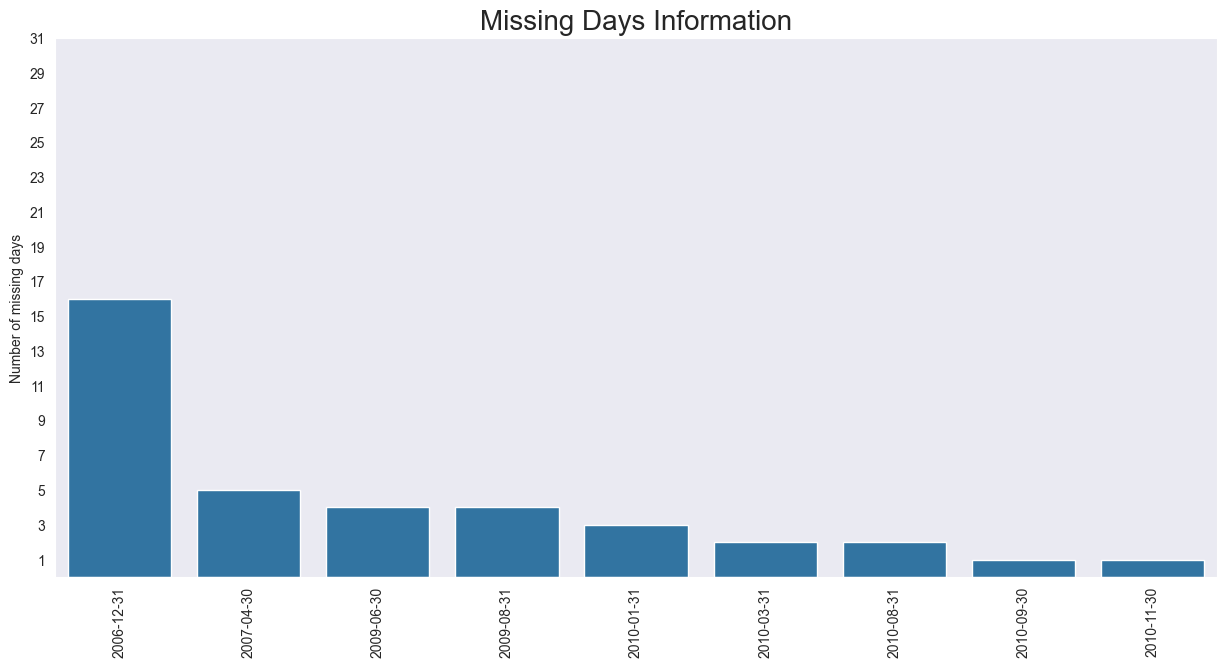

In [10]:
# Let's find out how many days have not been recoreded in our dataset
import seaborn as sns
missing_days_df = np.round(full_df[['Global_active_energy']].resample('ME').count()/1440).astype(int)
missing_days_df.columns = ['Number of missing days']
missing_days_df['Number of missing days'] = missing_days_df.index.astype(str).str[-2:].astype(int) - missing_days_df['Number of missing days']
# Drop the rows where the number of missing days is 0
missing_days_df.drop(missing_days_df[missing_days_df['Number of missing days']==0].index,inplace=True)

# Drawing the plot
plt.figure(figsize=(15,7))
sns.barplot(
    data = missing_days_df,
    x = missing_days_df.index.date,
    y = missing_days_df.sort_values(by=['Number of missing days'],ascending=False)['Number of missing days']
)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1,32,2))
plt.xlabel('')
plt.grid(axis='y')
plt.title('Missing Days Information',fontsize=20)
plt.show()

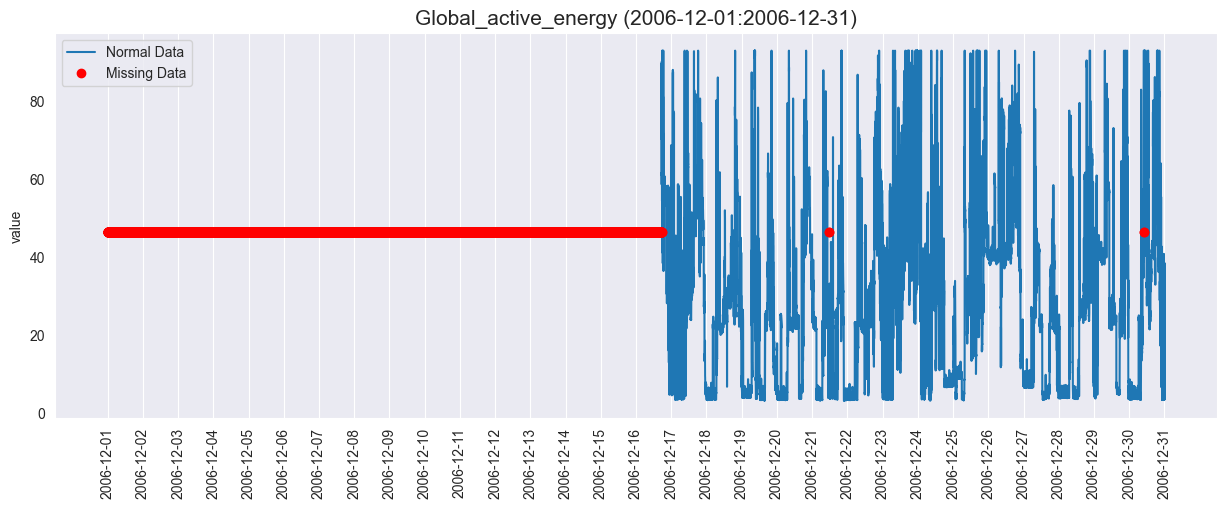

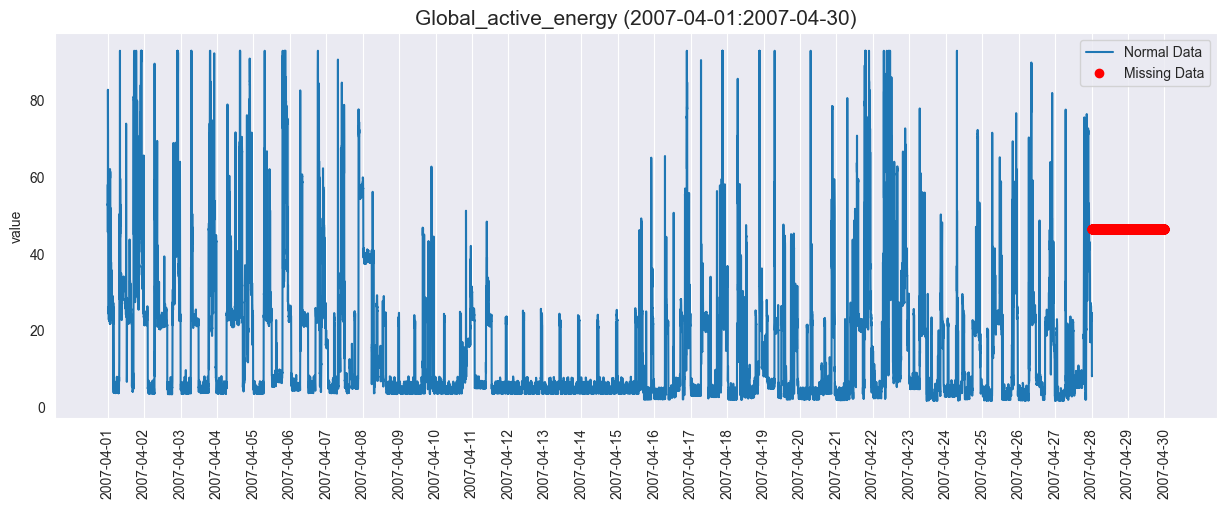

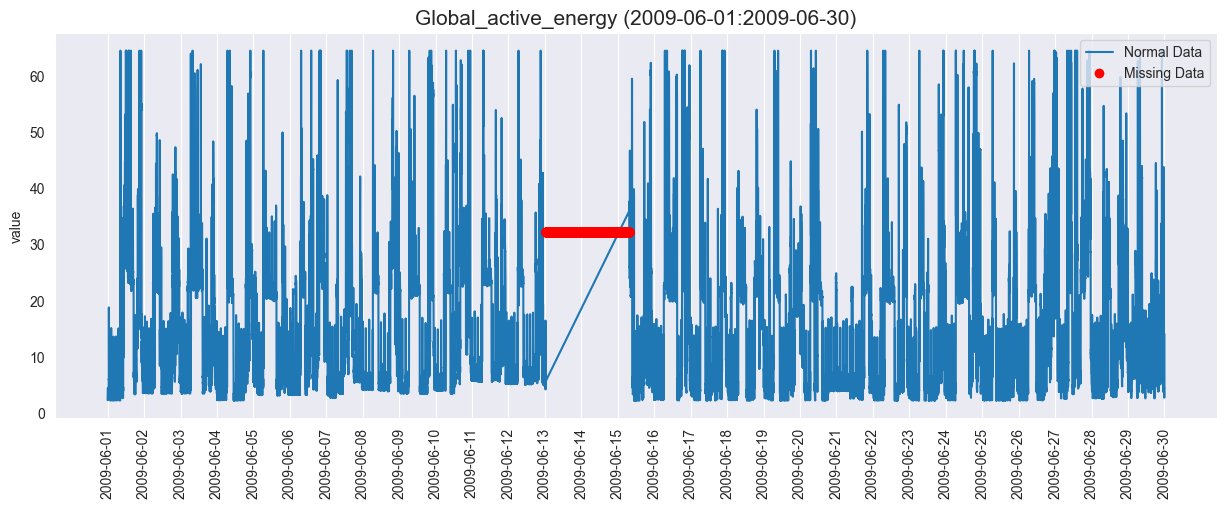

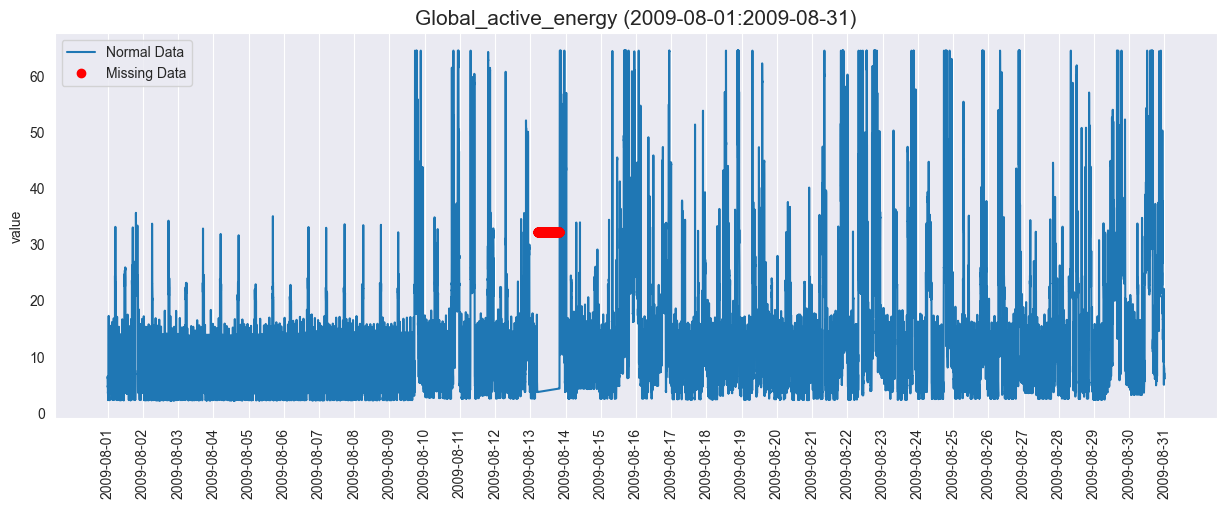

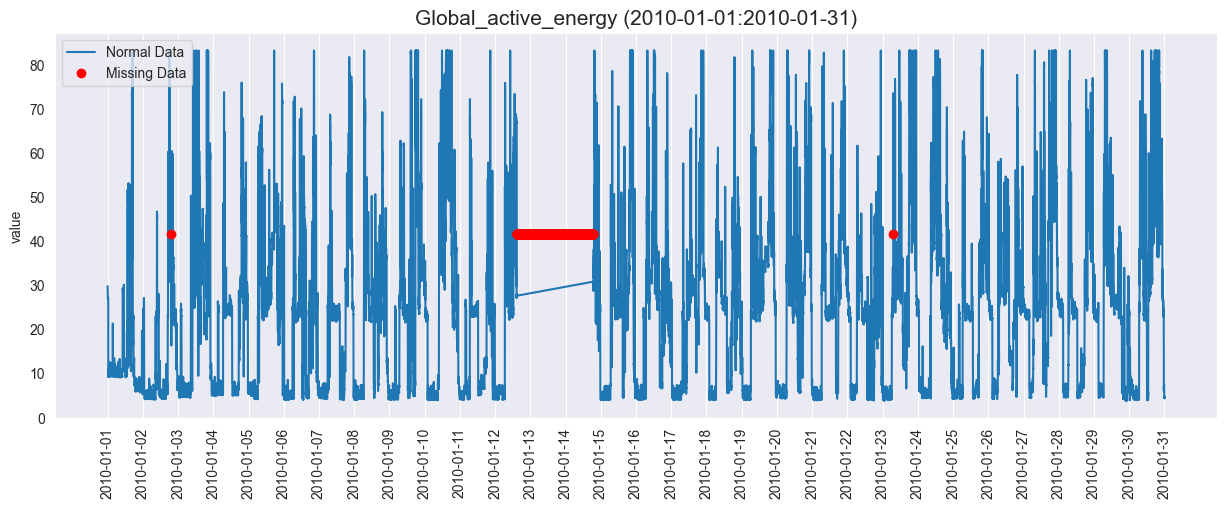

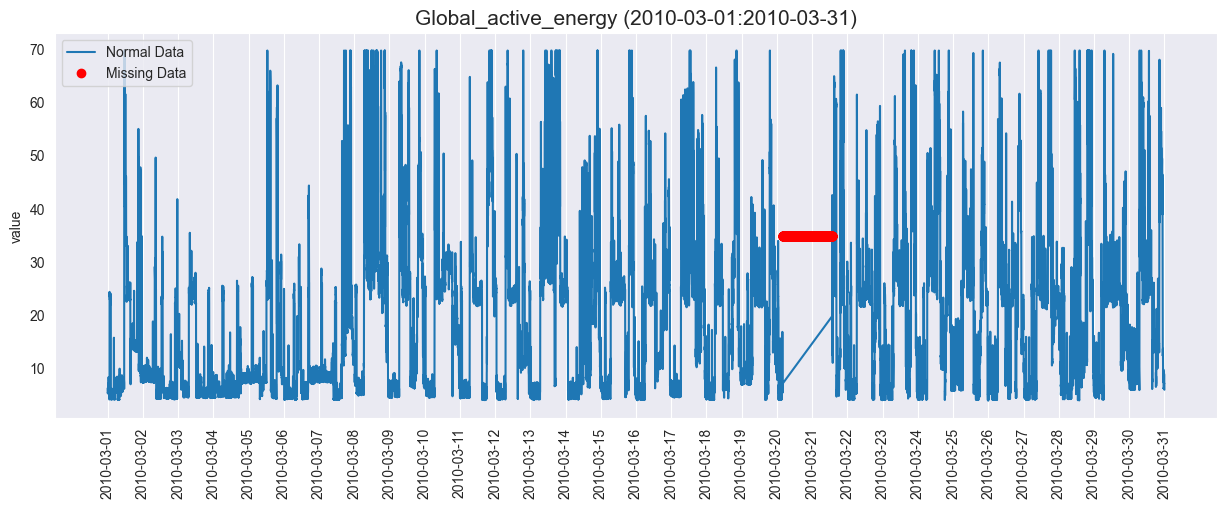

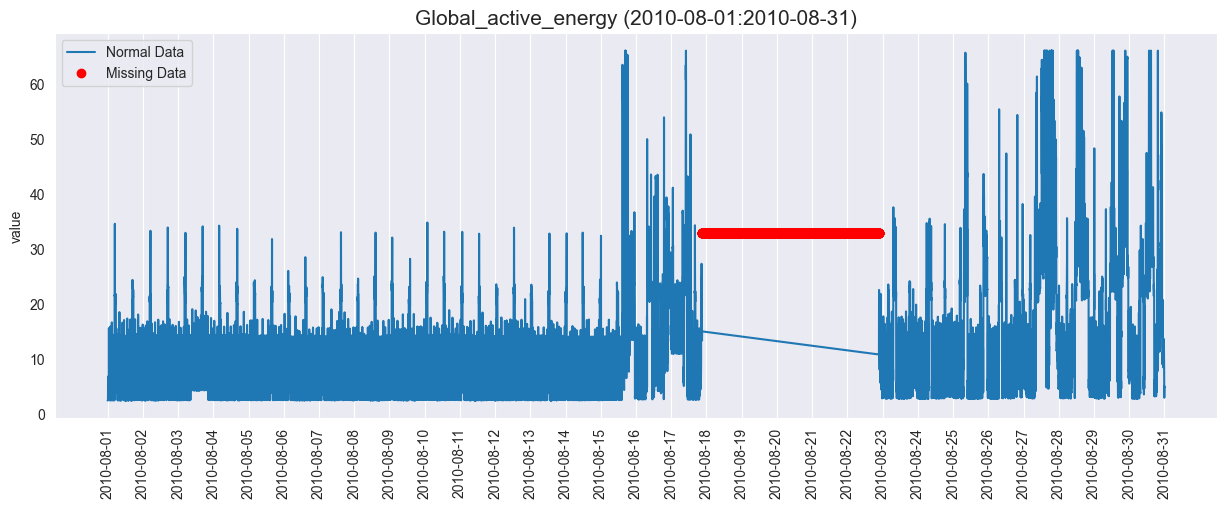

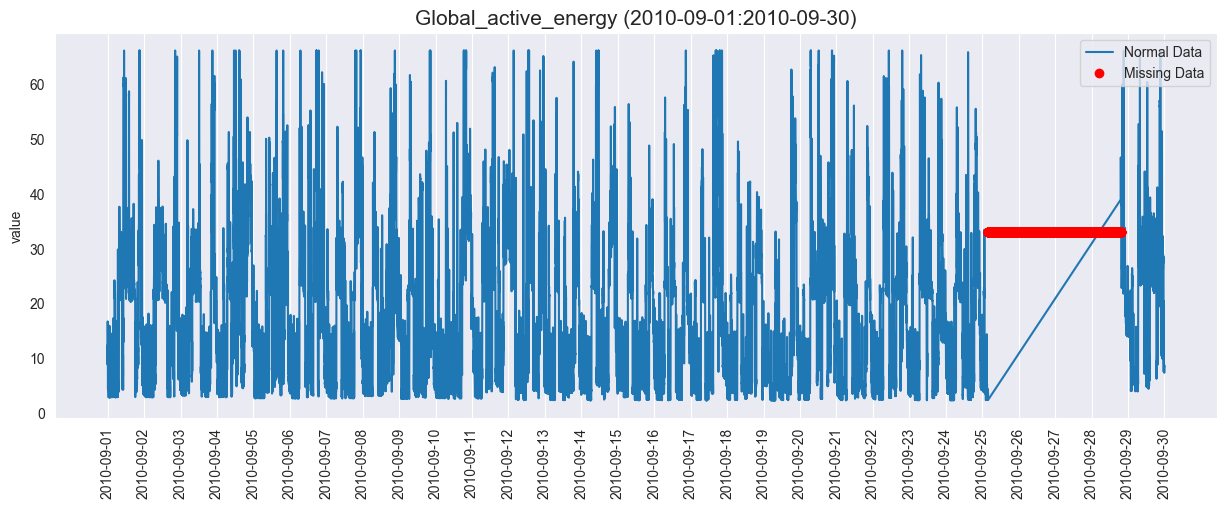

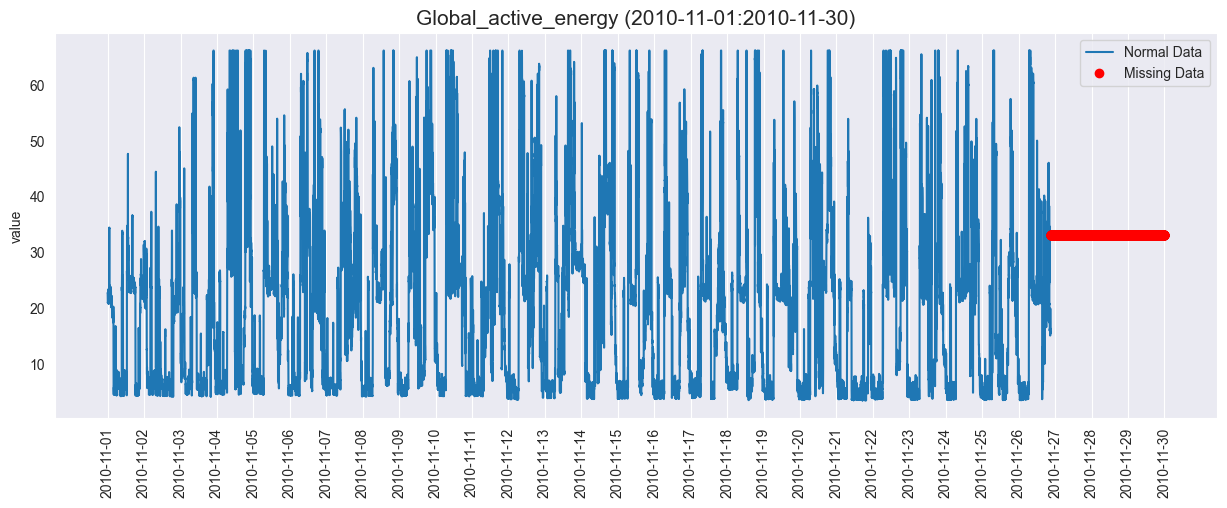

In [12]:
import datetime
def plot_day_data(day:datetime.date) -> None:
    '''
    The function "plot_day_data" plots the "Global_active_energy" values 
    for a given date as input. The input date is used to filter the data
    and fill in any missing values with NaN. On the plot, the missing
    values are marked with markers. The X-axis displays xticks for the
    specified day and the Y-axis is labeled as "value". The final plot 
    is displayed using the matplotlib library.
    
    Parameters:
        day : datetime.date
        
    Return:
        None
    '''
    # Create time range and xtick for the day
    time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1min')
    xtick_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='D')
    
    # Filter the data for the day and fill missing values with NaN
    tmp_df = full_df[['Global_active_energy']][full_df.index.isin(time_range)].copy()
    tmp_df = tmp_df.combine_first(pd.DataFrame(index=time_range, columns=tmp_df.columns))
    
    # Calculate the marker place
    marker_place = tmp_df[['Global_active_energy']].max().item() / 2
    # Identify the missing values
    missing_values = tmp_df.isna().any(axis=1)
    
    # Drawing the plot
    plt.figure(figsize=(15, 5))
    plt.plot(
        tmp_df[['Global_active_energy']][~missing_values],
        label = 'Normal Data'
    )
    plt.plot(
        tmp_df[['Global_active_energy']][missing_values].fillna(marker_place), 
        marker='o', 
        linestyle='None',
        label = 'Missing Data',
        color = 'r'
    )
    plt.xticks(xtick_range, rotation=90)
    plt.grid(axis='y')
    plt.title('Global_active_energy ({}:{})'.format(str(time_range[1].date()),str(time_range[-1].date())),fontsize=15)
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return None
for day in missing_days_df.index.date:
    plot_day_data(day)

#### Conclusions
As was reported in the dataset information, we can see that the data contains missing data as gaps.
The data collection for the first month didn't start from the beginning of the month, but on the 17th (Dec 2006).  
The data collection for the last month ended before the end of the month, on the 27th (Nov. 2010). 
There are 7 more gaps, as seen in the plots above.

## 2.1 Visualize Time Series Trends

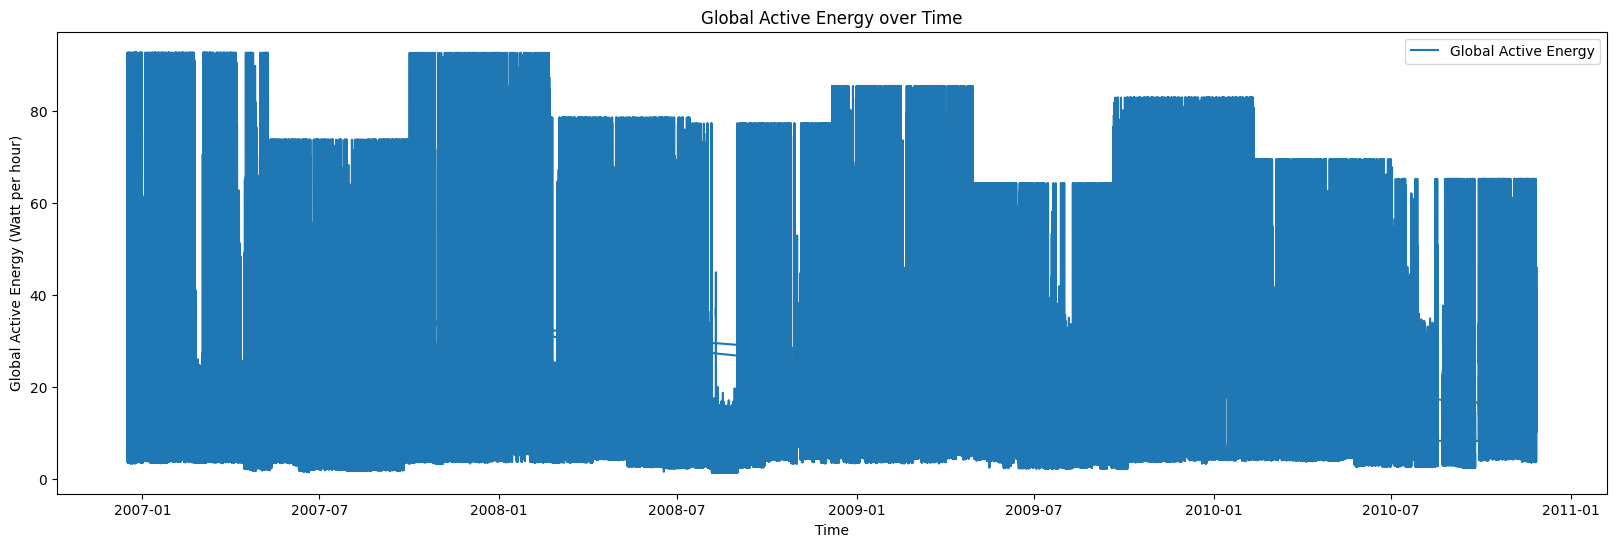

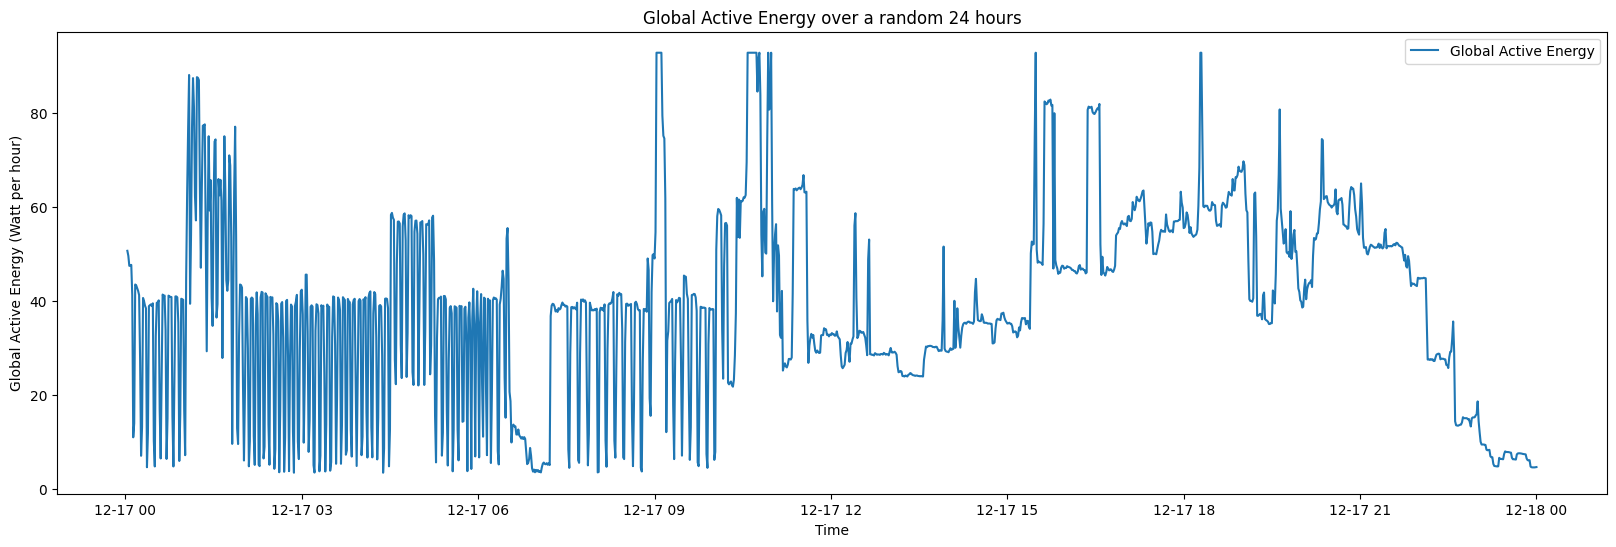

                     Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:00:00             4.113778               0.229000  234.643889   
2006-12-16 18:00:00             3.568400               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000   
2006-12-

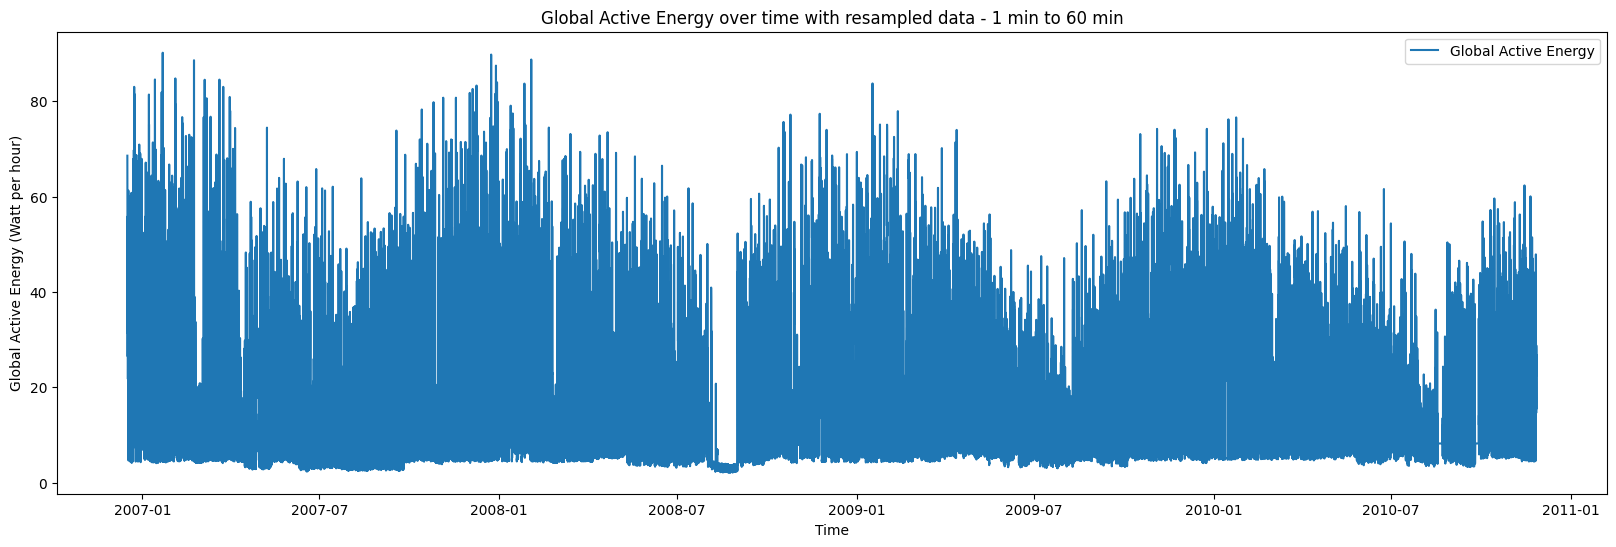

            Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                             
2006-12-16             3.033889               0.088187  236.243763   
2006-12-17             2.348171               0.156949  240.087028   
2006-12-18             1.530024               0.112356  241.231694   
2006-12-19             1.144707               0.104821  241.999313   
2006-12-20             1.543597               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2006-12-16         13.082828        0.000000        1.378788       12.439394   
2006-12-17          9.999028        1.411806        2.907639        9.264583   
2006-12-18          6.421667        0.738194        1.820139        9.734722   
2006-12-19          4.926389        0.582639        5.279167        4.303472   
2006-12-20          6.467361 

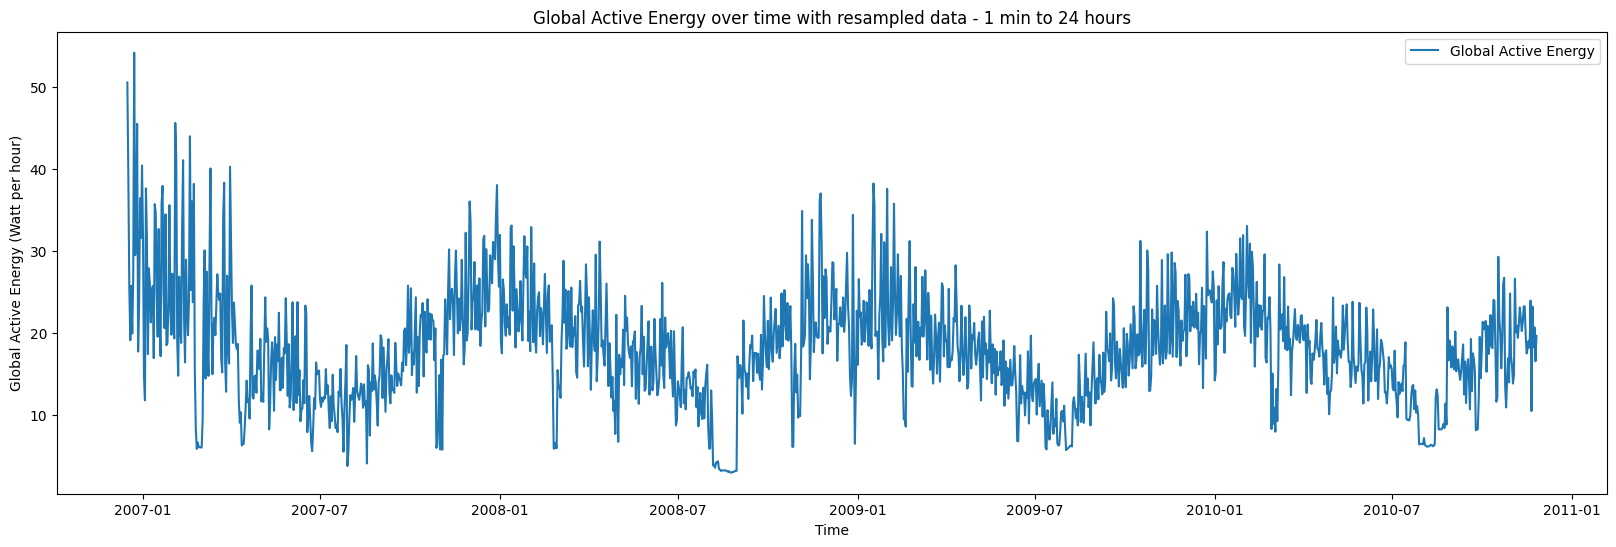

In [25]:
def visualize_time_series_trends(df: pd.DataFrame, title = "Global Active Energy over Time"):
    # Plot Global_active_power over time
    plt.figure(figsize=(20, 6))
    plt.plot(df["Global_active_energy"], label="Global Active Energy")
    plt.xlabel("Time")
    plt.ylabel("Global Active Energy (Watt per hour)")
    plt.title(title)
    plt.legend()
    plt.show()


visualize_time_series_trends(full_df) # Visualizing only all the df without changes
visualize_time_series_trends(full_df.iloc[398:1837], "Global Active Energy over a random 24 hours" ) # Visualizing only 24 hours from original df

from data_modification.resolution import resample_data
resampled_1min_to_60min_df = resample_data(full_df,'60min') # Resampling the data for better visualization
visualize_time_series_trends(resampled_1min_to_60min_df, "Global Active Energy over time with resampled data - 1 min to 60 min" )
resampled_1min_to_24h_df = resample_data(full_df,'1440min') # Resampling the data for better visualization
visualize_time_series_trends(resampled_1min_to_24h_df, "Global Active Energy over time with resampled data - 1 min to 24 hours" )

## 2.2 Check for Seasonality and Cyclical Patterns

In [27]:
def check_seasonality_and_cyclical_patterns(df: pd.DataFrame):
    # Decompose the time series
    decomposition = seasonal_decompose(
        df["Global_active_energy"].dropna(), model="additive", period=24 * 60
    )

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label="Observed")
    plt.legend(loc="upper right")
    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend")
    plt.legend(loc="upper right")
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal")
    plt.legend(loc="upper right")
    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual")
    plt.legend(loc="upper right")
    plt.show()


check_seasonality_and_cyclical_patterns(resampled_1min_to_24h_df)

ValueError: x must have 2 complete cycles requires 2880 observations. x only has 1442 observation(s)

## 2.3 Analyze Distribution of Power Consumption

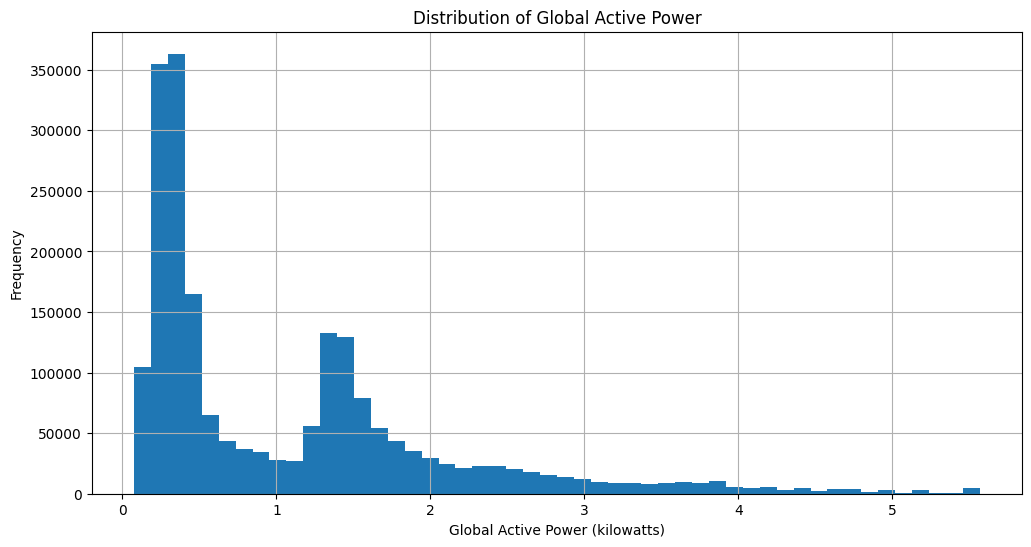

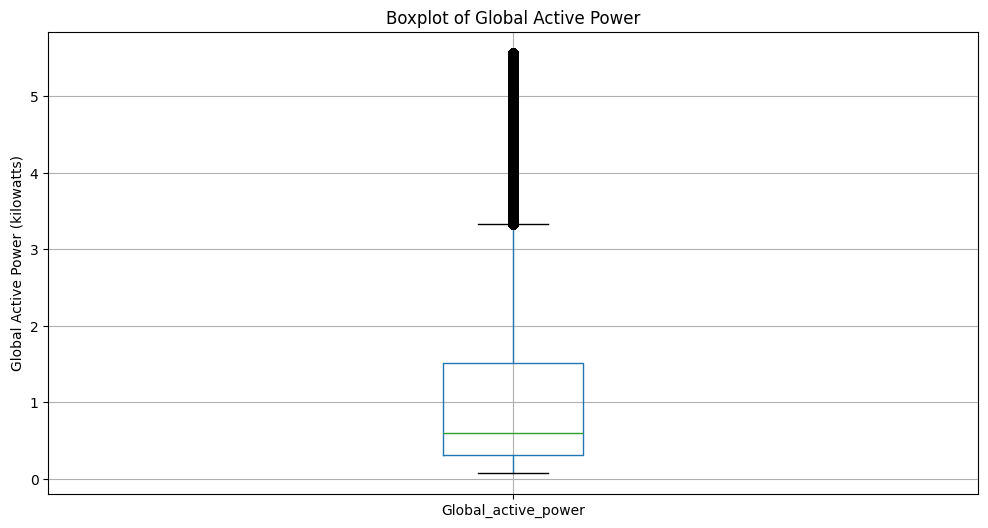

In [11]:
def analyze_distribution_of_power_consumption(df: pd.DataFrame):
    # Plot histogram
    plt.figure(figsize=(12, 6))
    df["Global_active_power"].hist(bins=50)
    plt.xlabel("Global Active Power (kilowatts)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Global Active Power")
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    df.boxplot(column="Global_active_power")
    plt.ylabel("Global Active Power (kilowatts)")
    plt.title("Boxplot of Global Active Power")
    plt.show()

analyze_distribution_of_power_consumption(full_df)

# 3. Implement a linear regression model to predict power consumption for the last three time periods

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from src.task_2.models.linear_regression import split_data_append_lagged_features, run_linear_regression
from src.task_2.evaluation.model_evaluation import run_model_evaluation

In [13]:
from src.task_2.evaluation.model_evaluation import run_model_evaluation

In [14]:
X_train, X_test, y_train, y_test = split_data_append_lagged_features(full_df)
linear_reg = run_linear_regression(X_train, y_train, X_test, y_test)

# Make predictions on the testing data
y_pred_lr = linear_reg.predict(X_test)

# Evaluate the model
lr_results = run_model_evaluation(y_test, y_pred_lr)

Training set size: (1660204, 3)
Testing set size: (415052, 3)


# 4. Evaluate the linear regression model using appropriate metrics

In [15]:
print(json.dumps(lr_results, indent=1))

{
 "Mean Absolute Error (MAE)": 0.09091245342503254,
 "Mean Squared Error (MSE)": 0.061170089665457825,
 "Root Mean Squared Error (RMSE)": 0.2473258774682864,
 "R-squared (R\u00b2) value": 0.9405323432612778
}


# 5. Implement a Recurrent Neural Network (RNN) for power consumption prediction

In [16]:
from src.task_2.models.rnn import run_rnn_model_e2e

In [ ]:
run_rnn_model_e2e(full_df, epochs=6, batch_size=128)

C:\Users\Shany\PycharmProjects\Afeka_DL_course_labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/128
276693/276693 ━━━━━━━━━━━━━━━━━━━━ 1697s 6ms/step - loss: 0.0969
Epoch 2/128
276693/276693 ━━━━━━━━━━━━━━━━━━━━ 1845s 7ms/step - loss: 0.0627
Epoch 3/128
276693/276693 ━━━━━━━━━━━━━━━━━━━━ 2607s 9ms/step - loss: 0.0619
Epoch 4/128
 26796/276693 ━━━━━━━━━━━━━━━━━━━━ 1:20:47 19ms/step - loss: 0.0633

# 6. Implement Long Short-Term Memory (LSTM) for power consumption prediction

In [ ]:
from src.task_2.models.long_short_term_memory import run_lstm_model_e2e

In [ ]:
run_lstm_model_e2e(full_df)

# 7. Implement an LSTM model with an Attention layer for power consumption prediction

In [ ]:
from src.task_2.models.lstm_with_attention import run_lstm_with_attention_e2e

In [ ]:
run_lstm_with_attention_e2e(full_df)

# 8. Data augmentation experiment

In [ ]:
from task_2.data_modification.augmentation import add_noise, scale_data, shift_data, window_slicing

In [ ]:
X_combined = np.concatenate([X, add_noise(X), scale_data(X), shift_data(X), window_slicing(X)], axis=0)
y_combined = np.concatenate([y, y, y, y, y], axis=0)

In [ ]:
X_train_augment, X_test_augment, y_train_augment, y_test_augment = rnn_split(X_combined, y_combined)

# 9. Data reduction experiment

In [ ]:
from src.task_2.data_modification.augmentation import reduce_data_randomly

In [ ]:
# Apply reduction
X_reduced, y_reduced = reduce_data_randomly(X, y, reduction_factor=0.1)

# 10. Data resolution experiment

In [11]:
from data_modification.resolution import resample_data_from_1min_to_2min, resample_data

In [14]:
resampled_df = resample_data(full_df, '2min')

                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.788                  0.427  234.235   
2006-12-16 17:26:00                5.381                  0.500  233.515   
2006-12-16 17:28:00                3.593                  0.525  235.350   
2006-12-16 17:30:00                3.701                  0.520  235.155   
2006-12-16 17:32:00                3.665                  0.510  233.925   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              20.7             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             1.5   
2006-12-16 17:28:00              15.4             0.0             1.5   
2006-12-16 17:30:00              15.8             0.0             1.0   
2006-12-16 17:32:00          

# 11. Conclusion and insights